In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

from src.tcga_preprocess_utils import split_patients

from catboost import CatBoostClassifier
from mvlearn.embed import CCA, MCCA

import sys
sys.path.append("..")

In [2]:
RANDOM_STATE = 42

In [3]:
dna_breast = pd.read_csv('data/breast/DNA_breast.csv', index_col=0).set_index('sample').fillna(0.)
rna_breast = pd.read_csv('data/breast/RNA_breast.csv', index_col=0).set_index('sample')
methylation_breast = pd.read_csv('data/breast/Methylation_breast.csv', index_col=0).set_index('sample')

dna_kidney = pd.read_csv('data/kidney/DNA_kidney.csv', index_col=0).set_index('sample')
rna_kidney = pd.read_csv('data/kidney/RNA_kidney.csv', index_col=0).set_index('sample')
methylation_kidney = pd.read_csv('data/kidney/Methylation_kidney.csv', index_col=0).set_index('sample')

In [4]:
X_breast = [dna_breast.values, rna_breast.values, methylation_breast.values]
X_kidney = [dna_kidney.values, rna_kidney.values, methylation_kidney.values]

In [5]:
cca = MCCA(n_components=10, regs='oas', multiview_output=False)

X_breast_cca = cca.fit_transform(X_breast)
X_kidney_cca = cca.fit_transform(X_kidney)

factors_stacked = np.vstack([X_breast_cca, X_kidney_cca])

### Предсказание типа рака

In [6]:
train_indices, test_indices, target = split_patients()

X_train, X_test, y_train, y_test = factors_stacked[train_indices], factors_stacked[test_indices], target[train_indices], target[test_indices]

In [7]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.9151785714285714, F1: 0.7865168539325843


/home/eshevtsova/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/eshevtsova/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/eshevtsova/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/eshevtsova/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplot

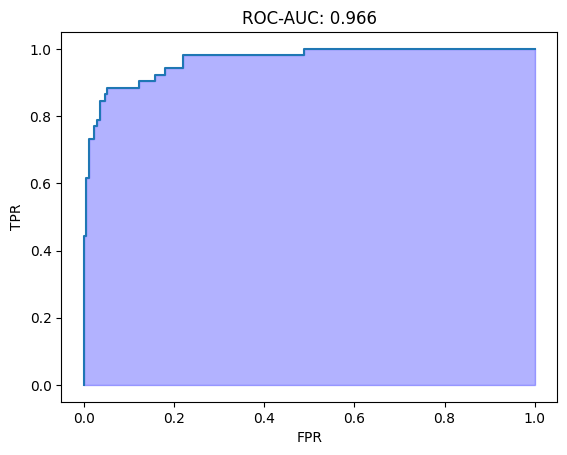

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {np.round(roc_auc, 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.fill_between(fpr, tpr, color= "b", alpha=0.3);